In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_hub as hub
import tensorflow_datasets as tfds

from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

In [ ]:
import keras
from keras.applications.inception_v3 import InceptionV3

from sklearn.metrics import confusion_matrix

from keras.metrics import categorical_crossentropy
from keras.metrics import binary_crossentropy
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.mobilenet import preprocess_input
from tensorflow.keras.preprocessing import image_dataset_from_directory
import tensorflow as tf
from keras.preprocessing import image

In [ ]:
train_datagen = image.ImageDataGenerator(
    rescale=1./255,
    shear_range = 0.3,
    zoom_range = 0.3,
    horizontal_flip = True,
)
validation_datagen = image.ImageDataGenerator(
    rescale = 1./255
)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/Tomato Maturity Detection Dataset/train',
    target_size = (224, 224),
    batch_size = 32,
    class_mode = 'categorical'
)

validation = validation_datagen.flow_from_directory(
    '/content/drive/MyDrive/Tomato Maturity Detection Dataset/val',
    target_size = (224, 224),
    batch_size = 32,
    class_mode = 'categorical'
)

test = validation_datagen.flow_from_directory(
    '/content/drive/MyDrive/Tomato Maturity Detection Dataset/test',
    target_size = (224, 224),
    batch_size = 32,
    shuffle = False,
    class_mode = 'categorical'
)

Found 3500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [ ]:
InceptionV3 = tf.keras.applications.InceptionV3(
    include_top=False,
    weights = 'imagenet',
    input_shape=(224,224,3),
    )

87910968/87910968 [==============================] - 0s 0us/step


In [ ]:
InceptionV3.trainable = False

In [ ]:
model = tf.keras.models.Sequential([
  InceptionV3,
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dropout(0.8),
  tf.keras.layers.Dense(units=1024, activation='relu'),
  tf.keras.layers.Dense(units=512, activation='relu'),
  tf.keras.layers.Dense(units=2, activation='sigmoid'),
])

In [ ]:
model.compile(
    optimizer = 'adam',
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 flatten (Flatten)           (None, 51200)             0         
                                                                 
 dropout (Dropout)           (None, 51200)             0         
                                                                 
 dense (Dense)               (None, 1024)              52429824  
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dense_2 (Dense)             (None, 2)                 1026      
                                                                 
Total params: 74758434 (285.18 MB)
Trainable params: 529

In [ ]:
history = model.fit(
    x = train,
    validation_data = validation,
    epochs = 10
)

Epoch 1/10
110/110 [==============================] - 1451s 13s/step - loss: 2.5266 - accuracy: 0.8477 - val_loss: 0.2722 - val_accuracy: 0.9200
Epoch 2/10
110/110 [==============================] - 780s 7s/step - loss: 0.1530 - accuracy: 0.9423 - val_loss: 0.1722 - val_accuracy: 0.9480
Epoch 3/10
110/110 [==============================] - 784s 7s/step - loss: 0.1601 - accuracy: 0.9420 - val_loss: 0.2678 - val_accuracy: 0.9320
Epoch 4/10
110/110 [==============================] - 851s 8s/step - loss: 0.1357 - accuracy: 0.9511 - val_loss: 0.1088 - val_accuracy: 0.9720
Epoch 5/10
110/110 [==============================] - 783s 7s/step - loss: 0.1127 - accuracy: 0.9580 - val_loss: 0.1426 - val_accuracy: 0.9580
Epoch 6/10
110/110 [==============================] - 900s 8s/step - loss: 0.1307 - accuracy: 0.9543 - val_loss: 0.1509 - val_accuracy: 0.9540
Epoch 7/10
110/110 [==============================] - 851s 8s/step - loss: 0.1175 - accuracy: 0.9609 - val_loss: 0.2054 - val_accuracy: 0.94

In [ ]:
# Evaluate the loss and accuracy
loss, accuracy = model.evaluate(test)

# Print the accuracy
print("Accuracy: " + str(accuracy))
# Print the loss
print("Loss: " + str(loss))

32/32 [==============================] - 339s 11s/step - loss: 0.1053 - accuracy: 0.9660
Accuracy: 0.9660000205039978
Loss: 0.10527601838111877


In [ ]:
test.class_indices

{'Immature': 0, 'Mature': 1}

In [ ]:
import numpy as np
from sklearn import metrics

predictions = model.predict(test)
predicted_classes = np.argmax(predictions, axis = 1)
true_classes = test.classes
class_labels = ['Immature','Mature']
report = metrics.classification_report(true_classes, predicted_classes, target_names = class_labels)
print(report)

32/32 [==============================] - 165s 5s/step
              precision    recall  f1-score   support

    Immature       0.97      0.96      0.97       500
      Mature       0.96      0.97      0.97       500

    accuracy                           0.97      1000
   macro avg       0.97      0.97      0.97      1000
weighted avg       0.97      0.97      0.97      1000



<Axes: >

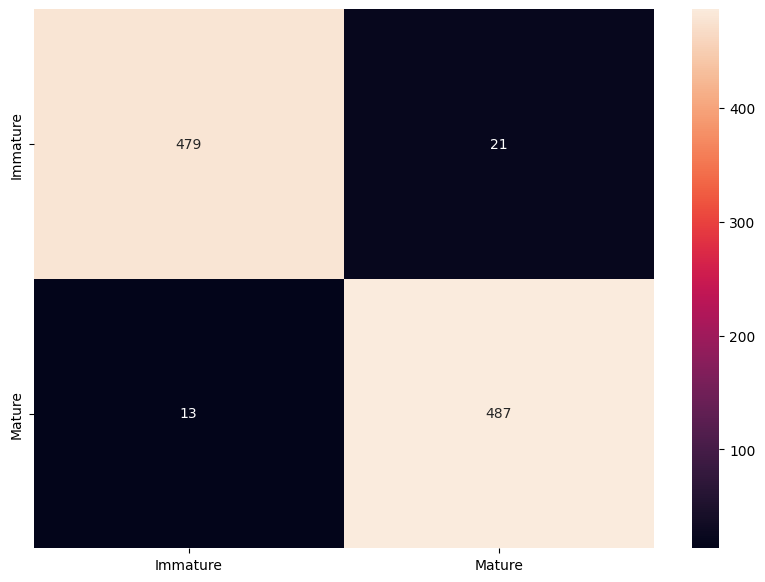

In [ ]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

cm = metrics.confusion_matrix(true_classes, predicted_classes)
df_cm = pd.DataFrame(cm, index = [i for i in ['Immature','Mature']],
                  columns = [i for i in ['Immature','Mature']])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, fmt='d')

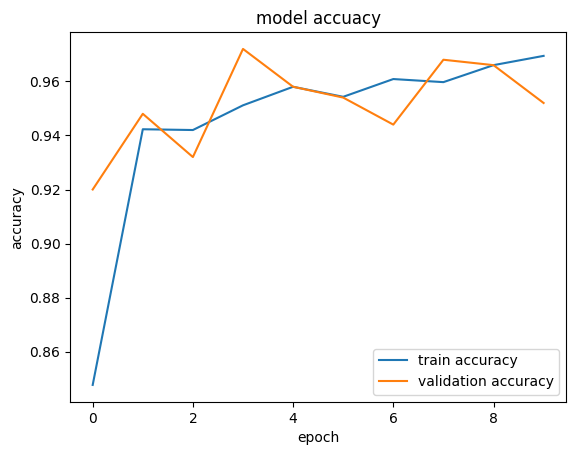

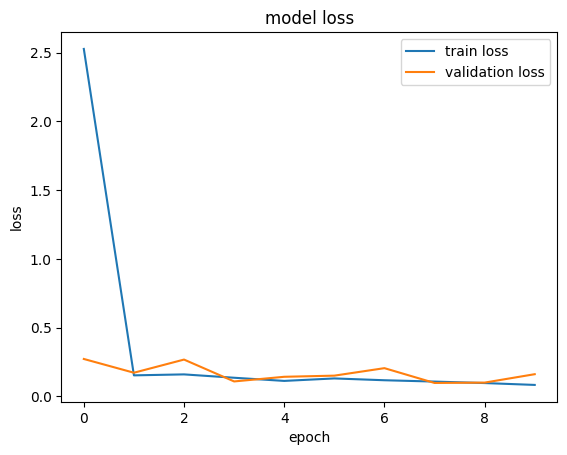

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("model accuacy")
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train accuracy', 'validation accuracy'], loc='lower right')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'validation loss'], loc='upper right')
plt.show()